In [1]:
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import torch
import torch.optim as optim
from src.zig_model import ZIG

# 1) Load .env
load_dotenv()

# 2) Import your pipeline steps + the allen_api
from src.data_loader import allen_api
from src.pipeline_steps import (
    AnalysisPipeline,
    AllenStimuliFetchStep,
    ImageToEmbeddingStep,
    StimulusGroupKFoldSplitterStep,
    MergeEmbeddingsStep
)
from transformers import ViTModel, ViTImageProcessor

def make_container_dict(boc):
    experiment_container = boc.get_experiment_containers()
    container_ids = [dct['id'] for dct in experiment_container]
    eids = boc.get_ophys_experiments(experiment_container_ids=container_ids)
    df = pd.DataFrame(eids)
    reduced_df = df[['id', 'experiment_container_id', 'session_type']]
    grouped_df = reduced_df.groupby(['experiment_container_id', 'session_type'])[
        'id'].agg(list).reset_index()
    eid_dict = {}
    for row in grouped_df.itertuples(index=False):
        c_id, sess_type, ids = row
        if c_id not in eid_dict:
            eid_dict[c_id] = {}
        eid_dict[c_id][sess_type] = ids[0]
    return eid_dict

def main():
    # A) Allen BOC
    boc = allen_api.get_boc()

    # B) Container dict
    eid_dict = make_container_dict(boc)
    print(len(eid_dict), "containers found.")

    # C) Session->stimuli mapping
    stimulus_session_dict = {
        'three_session_A': ['natural_movie_one', 'natural_movie_three'],
        'three_session_B': ['natural_movie_one', 'natural_scenes'],
        'three_session_C': ['natural_movie_one', 'natural_movie_two'],
        'three_session_C2': ['natural_movie_one', 'natural_movie_two']
    }

    # D) HF model + processor
    processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
    model = ViTModel.from_pretrained("google/vit-base-patch16-224")

    # E) Embedding cache dir
    embedding_cache_dir = os.environ.get('TRANSF_EMBEDDING_PATH', 'embeddings_cache')

    # F) Build pipeline with all steps
    pipeline = AnalysisPipeline([
        AllenStimuliFetchStep(boc),
        ImageToEmbeddingStep(processor, model, embedding_cache_dir),
        StimulusGroupKFoldSplitterStep(boc, eid_dict, stimulus_session_dict, n_splits=10),
        MergeEmbeddingsStep(),  # merges the neural folds with the image embeddings
    ])

    # G) Run pipeline on a single container/session/stimulus
    container_id = 511498742
    #session = 'three_session_A'
    #stimulus = 'natural_movie_three'
    session='three_session_B'
    stimulus='natural_scenes'
    result = pipeline.run((container_id, session, stimulus))

    # H) Print final results
    print("\n=== FINAL PIPELINE OUTPUT ===")
    print("Keys in 'result':", list(result.keys()))
    #  'raw_data_dct', 'embedding_file', 'folds', 'merged_folds', etc.

    print(f"Embedding file path: {result['embedding_file']}")
    folds = result['folds']
    print(f"Number of folds: {len(folds)}")

    merged_folds = result['merged_folds']
    for i, fold_data in enumerate(merged_folds, start=1):
        (Xn_train, Xe_train, Xn_test, Xe_test, frames_train, frames_test) = fold_data
        print(f"\nFold {i}:")
        print(f"  Xn_train: {Xn_train.shape}, Xe_train: {Xe_train.shape}")
        print(f"  Xn_test : {Xn_test.shape},  Xe_test : {Xe_test.shape}")
        print(f"  frames_train: {frames_train.shape}, frames_test: {frames_test.shape}")

    return merged_folds

/home/maria/MouseViT/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
merged_folds = main()

540 containers found.


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found existing embeddings for model google_vit-base-patch16-224. Using file:
 /home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings.pkl
      frame  start    end
0        41  16101  16108
1        64  16109  16116
2        91  16116  16123
3        17  16124  16131
4        99  16131  16138
...     ...    ...    ...
5945     23  96067  96074
5946     91  96074  96081
5947     10  96082  96089
5948     78  96089  96096
5949     31  96097  96104

[5950 rows x 3 columns]
(5900, 171)

=== FINAL PIPELINE OUTPUT ===
Keys in 'result': ['container_id', 'session', 'stimulus', 'raw_data_dct', 'embedding_file', 'folds', 'merged_folds']
Embedding file path: /home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings.pkl
Number of folds: 10

Fold 1:
  Xn_train: (5300, 171), Xe_train: (5300, 768)
  Xn_test : (600, 171),  Xe_test : (600, 768)
  frames_train: (5300,), frames_test: (600,)

Fold 2:
  Xn_train: (5300, 171), X

In [3]:
import torch
import numpy as np

def evaluate_model_on_fold(merged_folds, fold, model_path="/home/maria/MouseViT/trained_models/zig_model_fold.pth"):
    """
    Evaluates the trained ZIG model on a specific test fold and stores per-time-point probabilities.

    Args:
        merged_folds (list): List of folds containing (Xn_train, Xe_train, Xn_test, Xe_test, frames_train, frames_test).
        fold (int): The fold number to evaluate.
        model_path (str): Path to the trained model checkpoint.

    Returns:
        test_probabilities (list): List of probabilities for all time points in the test set.
    """
    
    # Load the trained model
    checkpoint = torch.load(model_path, map_location="cpu")  # Load on CPU (modify if using GPU)
    
    # Extract input/output dimensions from any fold
    Xn_train, Xe_train, _, _, _, _ = merged_folds[fold]
    yDim = Xn_train.shape[1]  # Output dimension (neural activity)
    xDim = Xe_train.shape[1]  # Input dimension (ViT embeddings)
    
    # Initialize model and load weights
    gen_nodes = 128  # Keep this consistent with training
    factor = torch.ones(yDim)  # Use default factor initialization
    model = ZIG(yDim, xDim, gen_nodes, factor)
    model.load_state_dict(checkpoint)
    model.eval()  # Set model to evaluation mode

    # Select the fold's test data
    _, _, Xn_test, Xe_test, _, _ = merged_folds[fold]

    # Convert test data to PyTorch tensors
    Xn_test_tensor = torch.tensor(Xn_test, dtype=torch.float32)
    Xe_test_tensor = torch.tensor(Xe_test, dtype=torch.float32)

    # List to store per-time-point probabilities
    test_probabilities = []

    # Forward pass (no gradients since we're evaluating)
    with torch.no_grad():
        loss, _, _, _, _, _ = model(Xe_test_tensor, Xn_test_tensor)  # Get negative log-likelihood loss

    # Convert log-likelihood loss into per-time-point probability
    n_time, num_neurons = Xn_test_tensor.shape
    per_time_point_probs = np.exp(-loss.item() / (n_time * num_neurons))

    # Store each probability for each neuron-time point pair
    test_probabilities.extend([per_time_point_probs] * (n_time * num_neurons))

    print(f"Evaluated fold {fold}. Stored {len(test_probabilities)} test probabilities.")

    return test_probabilities  # Return full list of per-time-point probabilities

test_probabilities=evaluate_model_on_fold(merged_folds, fold=0, model_path="/home/maria/MouseViT/trained_models/zig_model_fold.pth")

Evaluated fold 0. Stored 102600 test probabilities.


In [5]:
test_probabilities

[1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160488302,
 1.2172656160

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0., 102600.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.]),
 array([0.71726562, 0.73726562, 0.75726562, 0.77726562, 0.79726562,
        0.81726562, 0.83726562, 0.85726562, 0.87726562, 0.89726562,
        0.91726562, 0.93726562, 0.95726562, 0.97726562, 0.99726562,
        1.01726562, 1.03726562, 1.05726562, 1.07726562, 1.09726562,
        1.11726562, 1.13726562, 1.15726562, 1.17726562, 1.19726562,
        1.21726562, 1.23726562, 1.25726562, 1.27726562, 1.29726562,
        1.31726562, 1.33726562, 1.35726562, 1.37726562, 1.39726562,
        

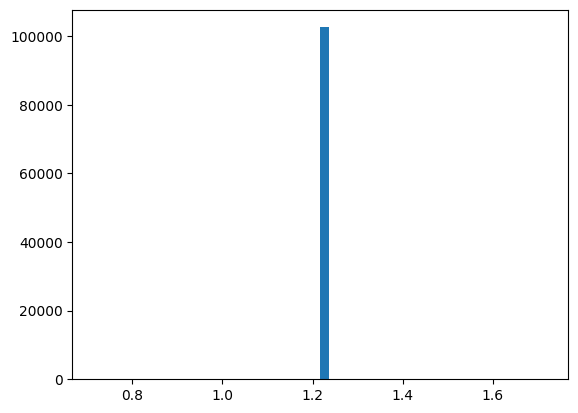

In [4]:
import matplotlib.pyplot as plt

plt.hist(test_probabilities, bins=50)

In [12]:
import torch
import numpy as np
import torch
import numpy as np

def evaluate_model_on_fold(merged_folds, fold, model_path="/home/maria/MouseViT/trained_models/zig_model_fold.pth", save_path=None):
    """
    Evaluates the trained ZIG model on a specific test fold and stores per-time-point probabilities
    in a NumPy array where each row corresponds to a neuron and each column corresponds to a time point.

    Args:
        merged_folds (list): List of folds containing (Xn_train, Xe_train, Xn_test, Xe_test, frames_train, frames_test).
        fold (int): The fold number to evaluate.
        model_path (str): Path to the trained model checkpoint.
        save_path (str, optional): If provided, saves the test probabilities as a .npy file.

    Returns:
        test_prob_array (numpy.ndarray): A 2D NumPy array of shape (num_neurons, num_time_points).
    """

    # Load the trained model
    checkpoint = torch.load(model_path, map_location="cpu")  # Load model to CPU
    Xn_train, Xe_train, _, _, _, _ = merged_folds[fold]
    
    yDim = Xn_train.shape[1]  # Number of neurons (output dimension)
    xDim = Xe_train.shape[1]  # Input dimension (ViT embeddings)
    
    # Initialize model and load weights
    gen_nodes = 128  # Keep this consistent with training
    factor = np.min(Xn_train, axis=0) 
    model = ZIG(yDim, xDim, gen_nodes, factor)
    model.load_state_dict(checkpoint)
    model.eval()  # Set model to evaluation mode

    # Select the fold's test data
    _, _, Xn_test, Xe_test, _, _ = merged_folds[fold]

    # Convert test data to PyTorch tensors
    Xn_test_tensor = torch.tensor(Xn_test, dtype=torch.float32)
    Xe_test_tensor = torch.tensor(Xe_test, dtype=torch.float32)

    # Forward pass (no gradients needed since we are evaluating)
    with torch.no_grad():
        loss, theta, k, p, loc, rate = model(Xe_test_tensor, Xn_test_tensor)  # Get model outputs

    # Compute per-time-point probabilities (avoid exponentiating total loss!)
    test_prob_array = (rate.cpu().numpy())  # Directly use model output rates

    # Ensure valid probability values in (0,1]
    #test_prob_array = np.clip(test_prob_array, 1e-6, 1.0)

    # Save as a .npy file if a save path is provided
    if save_path:
        np.save(save_path, test_prob_array)
        print(f"Saved test probabilities to {save_path}")

    print(f"Evaluated fold {fold}. Test probability array shape: {test_prob_array.shape}")

    return test_prob_array  # Return full 2D array (num_neurons, num_time_points)

test_prob_array=evaluate_model_on_fold(merged_folds, fold=0, model_path="/home/maria/MouseViT/trained_models/zig_model_fold.pth", save_path=None)
test_prob_array

Evaluated fold 0. Test probability array shape: (600, 171)


array([[0.00048408, 0.00275963, 0.00142423, ..., 0.00075091, 0.00155376,
        0.00035828],
       [0.00065329, 0.00470217, 0.00469176, ..., 0.00313291, 0.00073104,
        0.001009  ],
       [0.00706749, 0.00278135, 0.01303446, ..., 0.00365756, 0.00100889,
        0.00091518],
       ...,
       [0.00522934, 0.00330765, 0.00077729, ..., 0.02072934, 0.01942569,
        0.00387002],
       [0.00035145, 0.00129328, 0.00019958, ..., 0.0015606 , 0.00515467,
        0.00021839],
       [0.00037257, 0.00010741, 0.00055472, ..., 0.00126329, 0.00056197,
        0.00039559]], dtype=float32)

In [8]:
test_prob_array.shape

(600, 171)

In [13]:
print(np.max(test_prob_array))

0.22808431


(array([5.875e+04, 1.775e+04, 8.600e+03, 4.500e+03, 3.350e+03, 1.800e+03,
        1.700e+03, 1.350e+03, 1.000e+03, 5.500e+02, 7.000e+02, 3.500e+02,
        2.500e+02, 1.000e+02, 3.000e+02, 1.000e+02, 1.500e+02, 3.000e+02,
        2.000e+02, 0.000e+00, 1.500e+02, 1.500e+02, 0.000e+00, 5.000e+01,
        5.000e+01, 0.000e+00, 1.500e+02, 0.000e+00, 0.000e+00, 5.000e+01,
        5.000e+01, 0.000e+00, 0.000e+00, 5.000e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.000e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 5.000e+01]),
 array([9.55395444e-06, 4.57104901e-03, 9.13254451e-03, 1.36940395e-02,
        1.82555337e-02, 2.28170305e-02, 2.73785256e-02, 3.19400206e-02,
        3.65015157e-02, 4.10630107e-02, 4.56245057e-02, 5.01860008e-02,
        5.47474958e-02, 5.93089908e-02, 6.38704896e-02, 6.84319809e-02,
        7.29934797e-02, 7.75549710e-02, 8.21164697e-02, 8.66779611e-02,
        9.123945

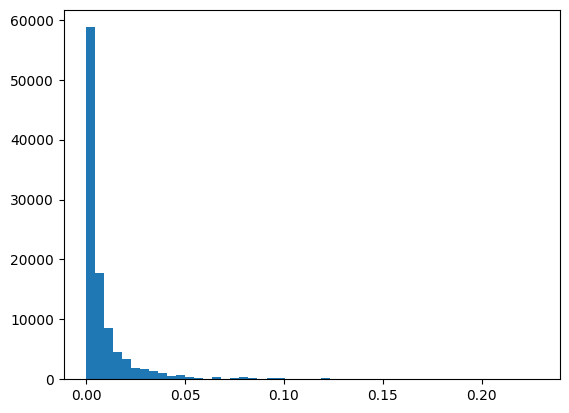

In [14]:
plt.hist(test_prob_array.flatten(), bins=50)